Each models is required to generate a stack ranking of all properties listed for sale in the database.

This script runs daily, reads in CSV files with a sorted order of homes (most attractive at the top to least attractive at the bottom), and a 'ypred' variable that reflects the scripts absolute metric (like P&L or probability of sale).

The script compares each list with homes that were sold, and identifies closed transactions ('positives') as well as the top 10 properties that each model identified that didn't sell ('negatives'). The remainder is considered 'control set'. 

For the overall data set, and specifically for each of those 3 groups, we output the average 'ypred' value, what number and percentage of homes sold from each.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
from slacker import Slacker
import json
import requests
from cloudinary.uploader import upload
from cloudinary.utils import cloudinary_url
from cloudinary.api import delete_resources_by_tag, resources_by_tag

csv_path = '/home/ilya/Code/rentalnerd/scraper/'
today = dt.date.today()


%matplotlib inline
        
# slack secrets (in your ~/.bashrc)
webhook_url = os.environ.get('SLACK_URL')
slacker = Slacker(os.environ.get('SLACK_TOKEN'))

# how old a target list to compare to the current target list
lag_days = 1

pd.set_option('display.max_colwidth', -1)
discount = 0.050

# to remove all the random far away areas - PHX only
zipcode_list = ['85006', '85007', '85008', '85009', '85013', '85015', '85016', '85017',
       '85018', '85019', '85020', '85021', '85022', '85023', '85024',
       '85027', '85028', '85029', '85031', '85033', '85035', '85037',
       '85040', '85041', '85043', '85044', '85048', '85050', '85051',
       '85053', '85085', '85086', '85087', '85118', '85138', '85139',
       '85142', '85143', '85202', '85203', '85204', '85205', '85206',
       '85207', '85209', '85210', '85212', '85213', '85215', '85224',
       '85225', '85226', '85233', '85234', '85248', '85249', '85250',
       '85251', '85253', '85254', '85255', '85257', '85258', '85262',
       '85266', '85286', '85295', '85296', '85297', '85298', '85301',
       '85302', '85303', '85304', '85305', '85306', '85308', '85310',
       '85323', '85326', '85331', '85335', '85339', '85340', '85351',
       '85353', '85355', '85373', '85374', '85375', '85382', '85383',
       '85388', '85390', '85392', '85396', '85704', '85705', '85706',
       '85711', '85712']

In [2]:
def plot_rounds(plot):
    # uploads the graph to the web and returns the URL
    
    fig = plot.get_figure()
    fig.tight_layout()
    fig.savefig('temp_plot.png')
    
    response = upload("temp_plot.png")
    url, options = cloudinary_url(response['public_id'],
        format = response['format'],
        crop = "fill")
    return url

In [3]:
def slack(text, url = None, title = None):
    print("Slacking: " + text)
    
    if url == None:
        data=json.dumps({"text": text})
    else:
        data = json.dumps( { "text": text, "attachments": [ { "fallback": "Model MAE"
                                           , "title": title
                                           , "image_url": url } ] } )
    
    response = requests.post(webhook_url, data , headers={'Content-Type': 'application/json'})
    if response.status_code != 200:
        raise ValueError('Request to slack returned an error %s, the response is:\n%s' % (response.status_code, response.text))


In [4]:
closed = pd.read_csv('CSV_backups/ALL-sales.csv',nrows=10000000, index_col=['property_id','transaction_id'])

In [5]:
closed.head()

,,price,transaction_status,date_listed,date_closed,days_on_market,transaction_type,price_listed,price_closed,date_transacted_latest,fsbo,...,school_district_id_68.0,school_district_id_75.0,school_district_id_76.0,school_district_id_8.0,school_district_id_87.0,school_district_id_90.0,school_district_id_93.0,school_district_id_95.0,school_district_id_96.0,school_district_id_nan
property_id,transaction_id,,,,,,,,,,,,,,,,,,,,,
8988529,22498354,80000,closed,2011-09-20,4365,85.0,sales,100000.0,80000.0,2011-12-14,0.0,...,0,0,0,0,0,0,0,0,0,0
8988522,22498256,261294,closed,NaN,5976,NaN,sales,NaN,261294.0,2016-05-12,0.0,...,0,0,0,0,0,0,0,0,0,0
1414628,22498210,159615,closed,NaN,6414,NaN,sales,NaN,159615.0,2017-07-24,0.0,...,0,0,0,0,0,0,0,0,0,0
8988519,22498203,320000,closed,NaN,4913,NaN,sales,NaN,320000.0,2013-06-14,0.0,...,0,0,0,0,0,0,0,0,0,0
8988518,22498197,91500,closed,NaN,4122,NaN,sales,NaN,91500.0,2011-04-15,0.0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# read in prior target list for backtesting purposes
prior_target_list = pd.read_csv(csv_path + 'good_sell/gs_target_list_' + (today-dt.timedelta(days=lag_days)) \
                                .strftime('%Y%m%d') + '.csv', index_col = [0,1]) \
                                .rename(columns = { 'ypred' : 'good_sell_prob'})
try:
    backtest = prior_target_list.join(closed[['price']], how="inner").sort_values(by='good_sell_prob',ascending=False)
    backtest['good_sell'] = (backtest.price >= (backtest.list * (1-discount)))
    y_all = prior_target_list.good_sell_prob.mean()
    y_sold = backtest.good_sell_prob.mean()

    pos_trigger = 0.6
    slack("Prior target list length: %i\tNum sold: %i\tAvg good sell prob: %f\tAvg good sell prob of sold: %f" 
          % (len(prior_target_list.index), len(backtest.index),y_all, y_sold))

    num_pos = len(prior_target_list[prior_target_list.good_sell_prob > pos_trigger].index)
    positives = backtest[backtest.good_sell_prob > pos_trigger]
    y_pos = (-(positives.price - positives.list) / positives.list).mean()
    num_sold = len(positives.index)
    if num_sold == 0:
        slack("Num of homes with good_sell_prob > %f: %i\tPerc of those sold: NONE\tAvg disc to list: NA" % (pos_trigger, num_pos) )    
    else:
        slack("Num of homes with good_sell_prob > %f: %i\tPerc of those sold: %f\tAvg disc to list: %f" 
              % (pos_trigger, num_pos, num_sold / num_pos *  100, y_pos * 100))

    neg_trigger = 0.3
    num_neg = len(prior_target_list[prior_target_list.good_sell_prob < neg_trigger].index)
    negatives = backtest[backtest.good_sell_prob < neg_trigger]
    y_neg = (-(negatives.price - negatives.list) / negatives.list).mean()
    num_sold = len(negatives.index)

    if num_sold == 0:
        slack("Num of homes with good_sell_prob < %f: %i\tPerc of those sold: NONE\tAvg disc to list: NA" % (neg_trigger, num_neg))
    else:
        slack("Num of homes with good_sell_prob < %f: %i\tPerc of those sold: %f\tAvg disc to list:%f" 
              % (neg_trigger, num_neg, len(negatives.index) / num_neg * 100, y_neg * 100))

    slack(backtest.to_string())
except Exception as err:   
    slack("No homes sold since last run")

Slacking: Prior target list length: 10580	Num sold: 1	Avg good sell prob: 0.503063	Avg good sell prob of sold: 0.512971
Slacking: Num of homes with good_sell_prob > 0.600000: 0	Perc of those sold: NONE	Avg disc to list: NA
Slacking: Num of homes with good_sell_prob < 0.300000: 0	Perc of those sold: NONE	Avg disc to list: NA
Slacking:                                                           address  zipcode  good_sell_prob    list                                                                                  url      lat     long   price good_sell
property_id transaction_id                                                                                                                                                                                                 
8949704     22183045        2006 W Weldon Ave, Phoenix, AZ 85015   85015    0.512971        167000  https://www.zillow.com/homedetails/2006-W-Weldon-Ave-Phoenix-AZ-85015/7517092_zpid/  33.4904 -112.102  167000  True    


In [7]:
# read in prior target list for backtesting purposes
prior_target_list = pd.read_csv(csv_path + 'value_buy/vb_target_list_' + (today-dt.timedelta(days=lag_days)) \
                                .strftime('%Y%m%d') + '.csv', index_col = [0,1]) \
                                .rename(columns = { 'ypred' : 'pnl'})

try:
    backtest = prior_target_list.join(closed['price'], how="inner").sort_values(by='pnl',ascending=False)
    backtest['good_sell'] = (backtest.price >= (backtest.list * (1-discount)))
    avg_pnl = backtest.pnl.mean()
    predicted_price = backtest.predicted_price.mean()
    sale_price = backtest.price.mean()

    slack("Prior target list length: %i\tNum sold: %i\tAvg P&L: %f\tAvg predict price: %f\tAvg sale price: %f" 
          % (len(prior_target_list.index), len(backtest.index),y_all, predicted_price, sale_price))

    pos_trigger = -10000
    num_pos = len(prior_target_list[prior_target_list.pnl > pos_trigger].index)
    positives = backtest[backtest.pnl > pos_trigger]
    y_pos = (-(positives.price - positives.list) / positives.list).mean()
    num_sold = len(positives.index)
    if num_sold == 0:
        slack("Num of homes with pnl > %f: %i\tPerc of those sold: NONE\tAvg disc to list: NA" % (pos_trigger, num_pos) )    
    else:
        slack("Num of homes with pnl > %f: %i\tPerc of those sold: %f\tAvg disc to list: %f" 
              % (pos_trigger, num_pos, num_sold / num_pos, y_pos))

    neg_trigger = -30000
    num_neg = len(prior_target_list[prior_target_list.pnl < neg_trigger].index)
    negatives = backtest[backtest.pnl < neg_trigger]
    y_neg = (-(negatives.price - negatives.list) / negatives.list).mean()
    num_sold = len(negatives.index)

    if num_sold == 0:
        slack("Num of homes with pnl < %f: %i\tPerc of those sold: NONE\tAvg disc to list: NA" % (neg_trigger, num_neg))
    else:
        slack("Num of homes with pnl < %f: %i\tPerc of those sold: %f\tAvg disc to list:%f" 
              % (neg_trigger, num_neg, len(negatives.index) / num_neg, y_neg))

    slack(backtest.to_string())
except Exception as err:   
    slack("No homes sold since last run")

Slacking: Prior target list length: 10581	Num sold: 1	Avg P&L: 0.503063	Avg predict price: 103493.187500	Avg sale price: 167000.000000
Slacking: Num of homes with pnl > -10000.000000: 87	Perc of those sold: NONE	Avg disc to list: NA
Slacking: Num of homes with pnl < -30000.000000: 10403	Perc of those sold: 0.000096	Avg disc to list:0.000000
Slacking:                                                           address  zipcode         pnl  predicted_price    list                                                                                  url   price good_sell
property_id transaction_id                                                                                                                                                                                            
8949704     22183045        2006 W Weldon Ave, Phoenix, AZ 85015   85015   -63506.8125  103493.1875      167000  https://www.zillow.com/homedetails/2006-W-Weldon-Ave-Phoenix-AZ-85015/7517092_zpid/  167000  True    


In [8]:
vb = pd.read_csv('value_buy/vb_target_list_' + today.strftime('%Y%m%d') + '.csv', index_col = ['property_id','transaction_id']) \
       .drop(['address','zipcode', 'url','list'],axis=1) \
       .rename(columns = { 'ypred': 'pnl'}) \
       .drop_duplicates()
    
gs = pd.read_csv('good_sell/gs_target_list_'  + today.strftime('%Y%m%d') + '.csv', index_col = ['property_id','transaction_id'])  \
       .rename(columns = { 'ypred' : 'good_sell_prob'}) \
       .drop_duplicates()
        
vb = vb[~vb.index.duplicated(keep='first')]
gs = gs[~gs.index.duplicated(keep='first')]
    
print("Len of value buy\t%i" % len(vb.index))
print("Len of good sell\t%i" % len(gs.index))

c = pd.concat([vb,gs],axis=1, join='inner')

c['pnl_percent'] = (c.pnl / c.list)

c = c[(c.list < 250000) & (c.list > 100000)  \
      & (~c.address.str.contains("Rent|rent|LOT|#|Sun City"))] 

Len of value buy	11714
Len of good sell	11723


/home/ilya/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Slacking: 


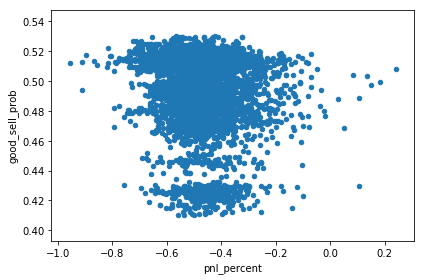

In [9]:
url = plot_rounds(c.query('good_sell_prob > 0.00').plot.scatter(x='pnl_percent', y='good_sell_prob'))
slack("", url, "Model Correlation")

In [10]:
# ran both data datasets and combine to create an equally weighted ensemble ranking
c["pnl_rank"] = c.pnl.rank(ascending=False)
c["gs_rank"] = c.good_sell_prob.rank(ascending=False)
c["rank"] = (c.pnl_rank + c.gs_rank)
c["zipcode"] = c.zipcode.apply(str)

# filter the output to remove duds
d = c[(c.pnl_percent > -0.2) & (c.good_sell_prob > 0.4) & (c.zipcode.isin(zipcode_list))]

d = c.sort("rank").nsmallest(20, "gs_rank")

file = csv_path + 'ensemble/comb_target_list_' + today.strftime('%Y%m%d') + '.csv'
np.round(d[['address', 'zipcode','list','predicted_price','pnl_percent','good_sell_prob','rank','url']], 4).to_csv(file)

slacker.files.upload(file, channels='#progress')

/home/ilya/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [11]:
for_sale = pd.read_csv('CSV_backups/ALL-for_sale.csv', index_col=['property_id','transaction_id'])
for_sale['zipcode'] = for_sale.zipcode.apply(str)

In [12]:
from math import radians, cos, sin, asin, sqrt
def haversine(row, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    lon1 = row.longitude
    lat1 = row.latitude
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km / 1.60934 # convert to miles

In [13]:
for r, target in d.iterrows():
    print(target.name[0])
    print(target.address)
    target.longitude = for_sale.loc[target.name].longitude
    target.latitude = for_sale.loc[target.name].latitude
    
    # get all properties listed for sale in the same zipcode as our target
    z = for_sale[(for_sale.zipcode == target.zipcode)]
    print(len(z.longitude))
    
    z['dist'] = z.apply(haversine, lon2 = target.longitude, lat2 = target.latitude, axis=1)
    print(z[['address','dist']].nsmallest(5,'dist'))
    

8962799
9937 E Empress Ave, Mesa, AZ 85208 
142
                                                          address      dist
property_id transaction_id                                                 
8962799     22186363        9937 E Empress Ave, Mesa, AZ 85208     0.000000
7416608     22199981        9912 E Escondido Ave, Mesa, AZ 85208   0.075229
7551414     22419125        9854 E Escondido Ave, Mesa, AZ 85208   0.120351
8981313     22484834        9861 E Emelita Ave, Mesa, AZ 85208     0.124616
8969104     22271645        9915 E El Moro Ave, Mesa, AZ 85208     0.168954
678798
8425 E Milagro Cir, Mesa, AZ 85209 
202
                                                        address      dist
property_id transaction_id                                               
678798      22105596        8425 E Milagro Cir, Mesa, AZ 85209   0.000000
678747      17862077        8419 E Milagro Cir, Mesa, AZ 85209   0.000000
678798      22105596        8425 E Milagro Cir, Mesa, AZ 85209   0.000000
678

/home/ilya/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/ilya/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/ilya/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


                                                                   address  \
property_id transaction_id                                                   
1485090     22027283        20051 N Coyote Lakes Pkwy, Surprise, AZ 85378    
1478611     21924000        11554 W Chuckwalla Ct, Surprise, AZ 85378        
1478304     22494956        11535 W King Snake Ct, Surprise, AZ 85378        
1478361     22262282        11538 W Coral Snake Ct, Surprise, AZ 85378       
8973325     22321345        11606 W Iron Court Mtn, Surprise, AZ 85378       
1478817     22304902        11606 W Iron Mountain Ct, Surprise, AZ 85378     

                                dist  
property_id transaction_id            
1485090     22027283        0.000000  
1478611     21924000        0.112463  
1478304     22494956        0.336386  
1478361     22262282        0.393586  
8973325     22321345        0.416659  
1478817     22304902        0.416659  
1848353
15491 W Maui Ln, Surprise, AZ 85379 
314
              

In [14]:
d

,,pnl,predicted_price,address,zipcode,good_sell_prob,list,url,lat,long,pnl_percent,pnl_rank,gs_rank,rank
property_id,transaction_id,,,,,,,,,,,,,
8962799,22186363,-118107.281250,89792.718750,"9937 E Empress Ave, Mesa, AZ 85208",85208,0.530421,207900,https://www.zillow.com/homedetails/9937-E-Empress-Ave-Mesa-AZ-85208/71621505_zpid/,33.3996,-111.616,-0.568097,3963.0,1.0,3964.0
678798,22105596,-98508.968750,134491.031250,"8425 E Milagro Cir, Mesa, AZ 85209",85209,0.530221,233000,https://www.zillow.com/homedetails/8425-E-Milagro-Cir-Mesa-AZ-85209/52434474_zpid/,33.3703,-111.653,-0.422785,2569.5,2.0,2571.5
1485090,22027283,-53674.789062,111325.210938,"20051 N Coyote Lakes Pkwy, Surprise, AZ 85378",85378,0.529724,165000,https://www.zillow.com/homedetails/20051-N-Coyote-Lakes-Pkwy-Surprise-AZ-85378/8318853_zpid/,33.6658,-112.308,-0.325302,314.0,6.0,320.0
1848353,21929232,-56379.101562,118620.898438,"15491 W Maui Ln, Surprise, AZ 85379",85379,0.529724,175000,https://www.zillow.com/homedetails/15491-W-Maui-Ln-Surprise-AZ-85379/55286216_zpid/,33.6209,-112.393,-0.322166,364.0,6.0,370.0
1145331,22260940,-61536.820312,88463.179688,"12229 W Larkspur Rd, El Mirage, AZ 85335",85335,0.529724,150000,https://www.zillow.com/homedetails/12229-W-Larkspur-Rd-El-Mirage-AZ-85335/29618318_zpid/,33.5965,-112.323,-0.410245,462.0,6.0,468.0
1140418,21895366,-87498.531250,70501.468750,"11601 W Poinsettia Dr, El Mirage, AZ 85335",85335,0.529724,158000,https://www.zillow.com/homedetails/11601-W-Poinsettia-Dr-El-Mirage-AZ-85335/59277980_zpid/,33.5917,-112.311,-0.553788,1761.0,6.0,1767.0
1147980,21956913,-92261.609375,76738.390625,"12477 W Via Camille, El Mirage, AZ 85335",85335,0.529724,169000,https://www.zillow.com/homedetails/12477-W-Via-Camille-El-Mirage-AZ-85335/60999747_zpid/,33.6161,-112.329,-0.545927,2098.0,6.0,2104.0
1492957,21994968,-99135.734375,75864.265625,"17523 W Ventura St, Surprise, AZ 85388",85388,0.529724,175000,https://www.zillow.com/homedetails/17523-W-Ventura-St-Surprise-AZ-85388/60995928_zpid/,33.6123,-112.436,-0.566490,2615.0,6.0,2621.0
1158809,21897068,-114389.890625,60510.105469,"14812 N El Frio St, El Mirage, AZ 85335",85335,0.529724,174900,https://www.zillow.com/homedetails/14812-N-El-Frio-St-El-Mirage-AZ-85335/71609102_zpid/,33.6193,-112.317,-0.654030,3760.0,6.0,3766.0
